In [25]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import threading
import heapq
from geopy.distance import geodesic

import time
import random

ox.settings.use_cache = True
ox.settings.log_console = False

⭐ Loading Ho Chi Minh City graph...


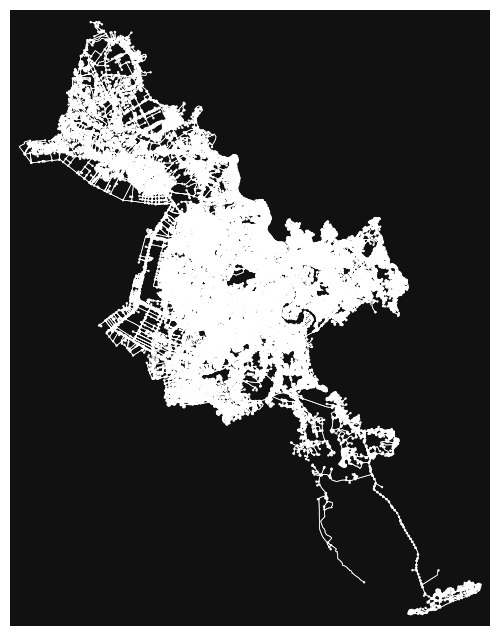

Start node: 366463208 (Thu Duc Market), Goal node: 2899065691 (Ben Thanh Market)


In [2]:
ox.settings.use_cache = True
ox.settings.log_console = False

# ---------- Load Ho Chi Minh City graph ----------
print("\u2b50 Loading Ho Chi Minh City graph...")
G = ox.graph_from_place('Ho Chi Minh City, Vietnam', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ox.plot_graph(G, node_size=3, edge_color='white', edge_linewidth=0.5)
plt.show()

# ---------- Define known locations ----------
start_gdf = ox.geocode_to_gdf('Thu Duc Market, Ho Chi Minh City')
if start_gdf.geometry.iloc[0].geom_type == 'Point':
    start_point = start_gdf.geometry.iloc[0]
else:
    start_point = start_gdf.geometry.iloc[0].centroid

goal_gdf = ox.geocode_to_gdf('Ben Thanh Market, Ho Chi Minh City')
if goal_gdf.geometry.iloc[0].geom_type == 'Point':
    goal_point = goal_gdf.geometry.iloc[0]
else:
    goal_point = goal_gdf.geometry.iloc[0].centroid

start_node = ox.distance.nearest_nodes(G, X=start_point.x, Y=start_point.y)
goal_node = ox.distance.nearest_nodes(G, X=goal_point.x, Y=goal_point.y)
print(f"Start node: {start_node} (Thu Duc Market), Goal node: {goal_node} (Ben Thanh Market)")


In [13]:
class Node:
    def __init__(self, value):
        self.value = value
        self.next = None
        self.lock = threading.Lock()

class FineGrainedSet:
    def __init__(self):
        self.head = Node(None)
        self.tail = Node(None)
        self.head.next = self.tail

    def add(self, value, priority):
        pred = self.head
        pred.lock.acquire()
        curr = pred.next
        curr.lock.acquire()
        try:
            while curr != self.tail and curr.value[1] < priority:
                pred.lock.release()
                pred, curr = curr, curr.next
                curr.lock.acquire()

            new_node = Node((value, priority))
            new_node.next = curr
            pred.next = new_node
        finally:
            curr.lock.release()
            pred.lock.release()

    def pop(self):
        self.head.lock.acquire()
        curr = self.head.next
        if curr == self.tail:
            self.head.lock.release()
            return None
        curr.lock.acquire()
        try:
            self.head.next = curr.next
            return curr.value
        finally:
            curr.lock.release()
            self.head.lock.release()

    def is_empty(self):
        self.head.lock.acquire()
        try:
            return self.head.next == self.tail
        finally:
            self.head.lock.release()

In [26]:
# ---------- Parallel A* ----------
def parallel_astar(G, start, goal, num_threads=4):
    open_set = FineGrainedSet()
    open_set.add(start, 0)
    g_score = {node: [float('inf'), float('inf')] for node in G.nodes}  # [distance, time]
    g_score[start] = [0, 0]
    came_from = {}
    lock = threading.Lock()
    result = {'found': False, 'path': []}

    def heuristic_vector(a, b):
        coord_a = (G.nodes[a]['y'], G.nodes[a]['x'])
        coord_b = (G.nodes[b]['y'], G.nodes[b]['x'])
        straight_line = geodesic(coord_a, coord_b).meters
        time_estimate = straight_line / 13.89  # ~50 km/h
        noise_distance = random.uniform(-0.1 * straight_line, 0.1 * straight_line)
        noise_time = random.uniform(-0.1 * time_estimate, 0.1 * time_estimate)
        return [straight_line + noise_distance, time_estimate + noise_time]

    def combine_f(g_vector, h_vector, weight_distance=0.7, weight_time=0.3):
        return weight_distance * (g_vector[0] + h_vector[0]) + weight_time * (g_vector[1] + h_vector[1])

    def worker():
        while not open_set.is_empty() and not result['found']:
            item = open_set.pop()
            if item is None:
                continue
            current, _ = item

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()
                with lock:
                    result['found'] = True
                    result['path'] = path
                return

            for neighbor in G.neighbors(current):
                edge_data = G.get_edge_data(current, neighbor)
                if edge_data is None:
                    continue
                edge_data = list(edge_data.values())[0]
                edge_distance = edge_data.get('length', float('inf'))
                edge_time = edge_data.get('travel_time', edge_distance / 13.89)
                tentative_g = [
                    g_score[current][0] + edge_distance,
                    g_score[current][1] + edge_time
                ]

                with lock:
                    if tentative_g[0] < g_score[neighbor][0]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g
                        f_score = combine_f(tentative_g, heuristic_vector(neighbor, goal))
                        open_set.add(neighbor, f_score)

    threads = [threading.Thread(target=worker) for _ in range(num_threads)]
    start_time = time.time()
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    end_time = time.time()
    print(f"Parallel A* (vector heuristic) runtime: {end_time - start_time:.2f} seconds")

    return result['path']

Parallel A* (vector heuristic) runtime: 0.29 seconds
Parallel A* path found with 128 nodes.


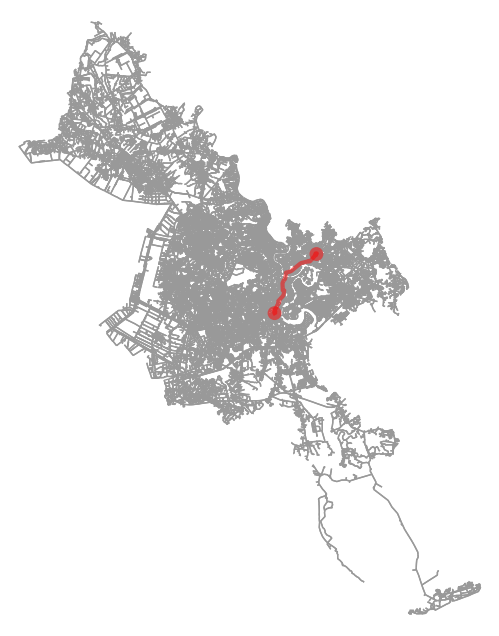

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
if start_gdf.geometry.iloc[0].geom_type == 'Point':
    start_point = start_gdf.geometry.iloc[0]
else:
    start_point = start_gdf.geometry.iloc[0].centroid

if goal_gdf.geometry.iloc[0].geom_type == 'Point':
    goal_point = goal_gdf.geometry.iloc[0]
else:
    goal_point = goal_gdf.geometry.iloc[0].centroid

start_node = ox.distance.nearest_nodes(G, X=start_point.x, Y=start_point.y)
goal_node = ox.distance.nearest_nodes(G, X=goal_point.x, Y=goal_point.y)

path_parallel = parallel_astar(G, start_node, goal_node, num_threads=4)
print(f"Parallel A* path found with {len(path_parallel)} nodes.")

ox.plot_graph_route(G, path_parallel, route_linewidth=3, node_size=0, bgcolor='white')

In [28]:
def benchmark(G, start_node, goal_node, thread_counts=[1, 2, 4, 8], seed=42):
    random.seed(seed)
    print(f"Benchmarking Parallel A* vs NetworkX shortest path with seed {seed}")

    # Run NetworkX shortest path (baseline)
    start_time = time.time()
    nx_path = nx.shortest_path(G, start_node, goal_node, weight='length')
    end_time = time.time()
    nx_time = end_time - start_time
    nx_length = sum(G.edges[u, v, 0]['length'] for u, v in zip(nx_path[:-1], nx_path[1:]))
    print(f"NetworkX shortest path time: {nx_time:.4f}s, path length: {nx_length:.2f}m")

    # Run Parallel A* for different thread counts
    for num_threads in thread_counts:
        random.seed(seed)  # reset seed for deterministic noise
        start_time = time.time()
        path_parallel = parallel_astar(G, start_node, goal_node, num_threads=num_threads)
        end_time = time.time()
        parallel_time = end_time - start_time

        if not path_parallel:
            print(f"Parallel A* (threads={num_threads}) failed to find a path.")
            continue

        parallel_length = sum(G.edges[u, v, 0]['length'] for u, v in zip(path_parallel[:-1], path_parallel[1:]))
        diff = abs(parallel_length - nx_length)
        percent_diff = (diff / nx_length) * 100
        
        print(f"Parallel A* (threads={num_threads}): time = {parallel_time:.4f}s, path length = {parallel_length:.2f}m, diff = {percent_diff:.2f}%")


In [30]:
if start_gdf.geometry.iloc[0].geom_type == 'Point':
    start_point = start_gdf.geometry.iloc[0]
else:
    start_point = start_gdf.geometry.iloc[0].centroid

if goal_gdf.geometry.iloc[0].geom_type == 'Point':
    goal_point = goal_gdf.geometry.iloc[0]
else:
    goal_point = goal_gdf.geometry.iloc[0].centroid

start_node = ox.distance.nearest_nodes(G, X=start_point.x, Y=start_point.y)
goal_node = ox.distance.nearest_nodes(G, X=goal_point.x, Y=goal_point.y)

benchmark(G, start_node, goal_node, thread_counts=[1, 2, 4, 8, 32, 64], seed=42)


Benchmarking Parallel A* vs NetworkX shortest path with seed 42
NetworkX shortest path time: 0.0628s, path length: 12973.56m
Parallel A* (vector heuristic) runtime: 0.32 seconds
Parallel A* (threads=1): time = 0.3417s, path length = 12973.56m, diff = 0.00%
Parallel A* (vector heuristic) runtime: 0.31 seconds
Parallel A* (threads=2): time = 0.3413s, path length = 12973.56m, diff = 0.00%
Parallel A* (vector heuristic) runtime: 0.28 seconds
Parallel A* (threads=4): time = 0.3080s, path length = 12973.56m, diff = 0.00%
Parallel A* (vector heuristic) runtime: 0.31 seconds
Parallel A* (threads=8): time = 0.6244s, path length = 12973.56m, diff = 0.00%
Parallel A* (vector heuristic) runtime: 0.33 seconds
Parallel A* (threads=32): time = 0.3512s, path length = 12973.56m, diff = 0.00%
Parallel A* (vector heuristic) runtime: 0.39 seconds
Parallel A* (threads=64): time = 0.4157s, path length = 12973.56m, diff = 0.00%
